In [1]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Convolution1D,Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hyliu24/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

## Load KS trajectories

In [4]:
num_train = 100
num_tests = 1
look_back = 15

N = 1024
T = 251
KS_input_data = np.zeros(((T-look_back)*(num_train-num_tests), look_back, N)) # Shape: (Nbatch, time, dim)
KS_target_data = np.zeros(((T-look_back)*(num_train-num_tests),N))

for i in range(num_train-num_tests):
    u = loadmat('PDECODES/KS_data/N'+str(N)+'/iter'+str(i+1)+'.mat')['uu']
    for l in range(look_back):
        KS_input_data[i*(T-look_back):(i+1)*(T-look_back),l] = u[:,l:-(look_back-l)].T
    KS_target_data[i*(T-look_back):(i+1)*(T-look_back)] = u[:,look_back:].T

In [5]:
KS_test_data = np.zeros((T*num_tests,N))
for i in range(num_tests):
    u = loadmat('PDECODES/KS_data/N'+str(N)+'/iter'+str(num_train-i)+'.mat')['uu']
    KS_test_data[i*T:(i+1)*T] = u.T

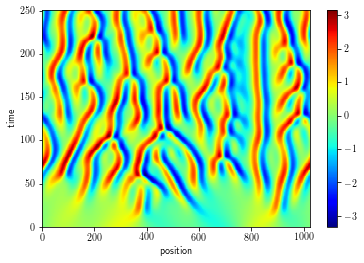

In [6]:
mpl.rcParams['text.usetex'] = True
m = plt.pcolor(KS_test_data,cmap='jet')
m.set_rasterized(True)
plt.xlabel('position')
plt.ylabel('time')
plt.colorbar()
#plt.savefig('img/sample_KS_trajectory.pdf')

## Train Neural Network

In [15]:
model = Sequential()
model.add(LSTM(N, activation="tanh", recurrent_activation="sigmoid", dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(N))

In [16]:
# Adam is the preferred choice
adam_ = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
model.compile(loss='mean_squared_error', optimizer=adam_, metrics=['accuracy'])
#plot_model(model, to_file='model.pdf', show_shapes=True)

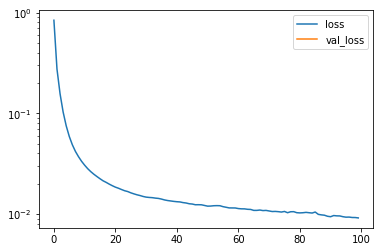

23364/23364 [==============================] - 48s 2ms/step - loss: 0.0091 - acc: 0.2888


In [17]:
mpl.rcParams['text.usetex'] = False
model.fit(
    KS_input_data,
    KS_target_data,
    epochs=100, batch_size=2000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [18]:
KS_NN_prediction = np.zeros(KS_test_data[0:T].shape)
KS_NN_prediction[0:look_back] = KS_test_data[0:look_back]
for k in range(T-look_back):
    pred_input = reshape(KS_NN_prediction[k:k+look_back], (look_back, KS_NN_prediction.shape[-1]))
    KS_NN_prediction[k+look_back] = model.predict(np.array([pred_input]))

In [24]:
print(pred_input.shape)
print(KS_NN_prediction.shape)

(15, 1024)
(251, 1024)


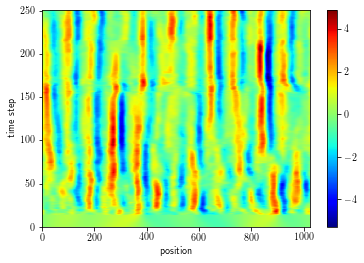

In [19]:
mpl.rcParams['text.usetex'] = True
m = plt.pcolor(KS_NN_prediction, cmap='jet')
m.set_rasterized(True)
plt.xlabel('position')
plt.ylabel('time step')
plt.colorbar()

0.10994607584299806


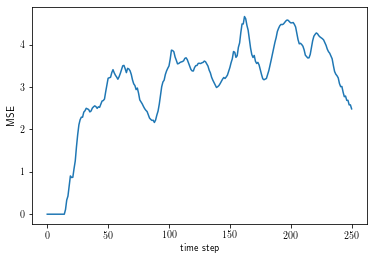

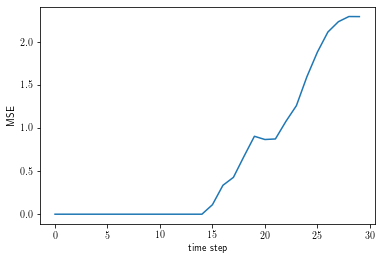

In [20]:
mse_total = ((KS_NN_prediction-KS_test_data[0:T])**2).mean(axis=None)
mse_over_step = ((KS_NN_prediction-KS_test_data[0:T])**2).mean(axis=-1)
mse_one_step = mse_over_step[look_back]

figure()
plt.plot(np.array(range(T)), mse_over_step)
xlabel('time step')
ylabel('MSE')

figure()
plt.plot(np.array(range(T)[0:30]), mse_over_step[0:30])
xlabel('time step')
ylabel('MSE')

print(mse_one_step)

# Training error (one step) is about 0.0091 at the end, test error (one step) is about 0.1099, 
# about 40 times that of the training error, hence there could be some overfitting and 
# techniques such as regularization, dropout and early stopping could be used. 
# Moreover, MSE shoots up over time, which limits the time horizon of the prediction. 

# However, this is better than without dropout, where training error achieves 0.003 and 
# test error is about 0.136

In [21]:
import pickle
results={'y_pred':KS_NN_prediction, 'y_test':KS_test_data, \
         'train_data':KS_input_data, 'train_target':KS_target_data}
f = open('KS_NN.pickle', 'wb')
pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()